# Feature Engineering and Clustering for Cryptocurrency Analysis

This notebook performs feature engineering, clustering (K-means and hierarchical), and generates deliverables for cryptocurrency behavioral analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import pearsonr
import json
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Cleaned Data and Metadata

In [2]:
# Load the cleaned dataset
df = pd.read_csv('../data/processed/crypto_data_cleaned.csv')
df['date'] = pd.to_datetime(df['date'])

# Load metadata
with open('../data/processed/metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"Loaded {len(df)} records for {df['slug'].nunique()} cryptocurrencies")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Loaded 879375 records for 1383 cryptocurrencies
Date range: 2013-04-28 00:00:00 to 2018-11-30 00:00:00


## 2. Feature Engineering

In [3]:
# Calculate daily returns
df = df.sort_values(['slug', 'date'])
df['daily_return'] = df.groupby('slug')['close'].pct_change()

# Calculate log returns for better statistical properties
df['log_return'] = np.log(df['close'] / df.groupby('slug')['close'].shift(1))

# Remove infinite values and NaN
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['daily_return', 'log_return'])

In [4]:
# Feature 1: Average Daily Return
avg_daily_return = df.groupby('slug')['daily_return'].mean()

# Feature 2: Volatility (Standard Deviation of Returns)
volatility = df.groupby('slug')['daily_return'].std()

# Feature 3: Sharpe Ratio (Risk-adjusted return)
# Assuming risk-free rate = 0 for simplicity
sharpe_ratio = avg_daily_return / volatility

# Feature 4: Maximum Drawdown
def calculate_max_drawdown(prices):
    cumulative = (1 + prices.pct_change()).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

max_drawdown = df.groupby('slug')['close'].apply(calculate_max_drawdown)

# Feature 5: Price Range (High-Low ratio)
price_range = df.groupby('slug').apply(lambda x: (x['high'].max() - x['low'].min()) / x['low'].min())

# Feature 6: Trading Volume Stability
volume_cv = df.groupby('slug')['volume'].apply(lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan)

In [5]:
# Feature 7: Correlation with Bitcoin
# Get Bitcoin data
bitcoin_data = df[df['slug'] == 'bitcoin'][['date', 'daily_return']].copy()
bitcoin_data.columns = ['date', 'btc_return']

# Calculate correlation with Bitcoin for each cryptocurrency
correlations_with_btc = {}

for slug in df['slug'].unique():
    if slug == 'bitcoin':
        correlations_with_btc[slug] = 1.0
        continue
    
    crypto_data = df[df['slug'] == slug][['date', 'daily_return']]
    merged = pd.merge(crypto_data, bitcoin_data, on='date', how='inner')
    
    if len(merged) > 30:  # Minimum 30 days for meaningful correlation
        corr = merged['daily_return'].corr(merged['btc_return'])
        correlations_with_btc[slug] = corr
    else:
        correlations_with_btc[slug] = np.nan

btc_correlation = pd.Series(correlations_with_btc)

In [6]:
# Create feature matrix
features_df = pd.DataFrame({
    'avg_daily_return': avg_daily_return,
    'volatility': volatility,
    'sharpe_ratio': sharpe_ratio,
    'max_drawdown': max_drawdown,
    'price_range': price_range,
    'volume_cv': volume_cv,
    'btc_correlation': btc_correlation
})

# Add metadata
crypto_info = df.groupby('slug').agg({
    'name': 'first',
    'unique_symbol': 'first',
    'market': 'mean',
    'volume': 'mean',
    'date': 'count'
})
crypto_info.columns = ['name', 'symbol', 'avg_market_cap', 'avg_volume', 'days_traded']

features_df = features_df.join(crypto_info)

# Remove rows with missing features
features_df = features_df.dropna()

print(f"Feature matrix shape: {features_df.shape}")
print(f"\nFeature statistics:")
features_df[['avg_daily_return', 'volatility', 'sharpe_ratio', 'max_drawdown', 
             'price_range', 'volume_cv', 'btc_correlation']].describe()

Feature matrix shape: (1383, 12)

Feature statistics:


,avg_daily_return,volatility,sharpe_ratio,max_drawdown,price_range,volume_cv,btc_correlation
count,1383.000000,1383.000000,1383.000000,1383.000000,1.383000e+03,1383.000000,1383.000000
mean,0.215700,5.012382,0.029350,-0.966800,3.100487e+05,3.403916,0.272763
std,3.994752,94.516738,0.065665,0.067190,9.813902e+06,2.703119,0.170625
min,-0.018741,0.010066,-0.234674,-1.000000,1.680632e-01,0.122335,-0.091132
25%,-0.001240,0.108261,-0.009085,-0.994546,4.543433e+01,1.558715,0.130537
50%,0.006086,0.155329,0.042892,-0.983055,1.675533e+02,2.510553,0.256051
75%,0.022396,0.286445,0.073152,-0.962567,1.450042e+03,4.225744,0.399320
max,127.895831,2969.193601,0.210816,-0.082878,3.631579e+08,25.640566,1.000000


## 3. Feature Scaling and Selection

In [7]:
# Select features for clustering
feature_columns = ['avg_daily_return', 'volatility', 'sharpe_ratio', 
                  'max_drawdown', 'price_range', 'btc_correlation']
X = features_df[feature_columns]

# Use RobustScaler to handle outliers better
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)

print("Features scaled successfully")
print(f"Scaled feature matrix shape: {X_scaled.shape}")

Features scaled successfully
Scaled feature matrix shape: (1383, 6)


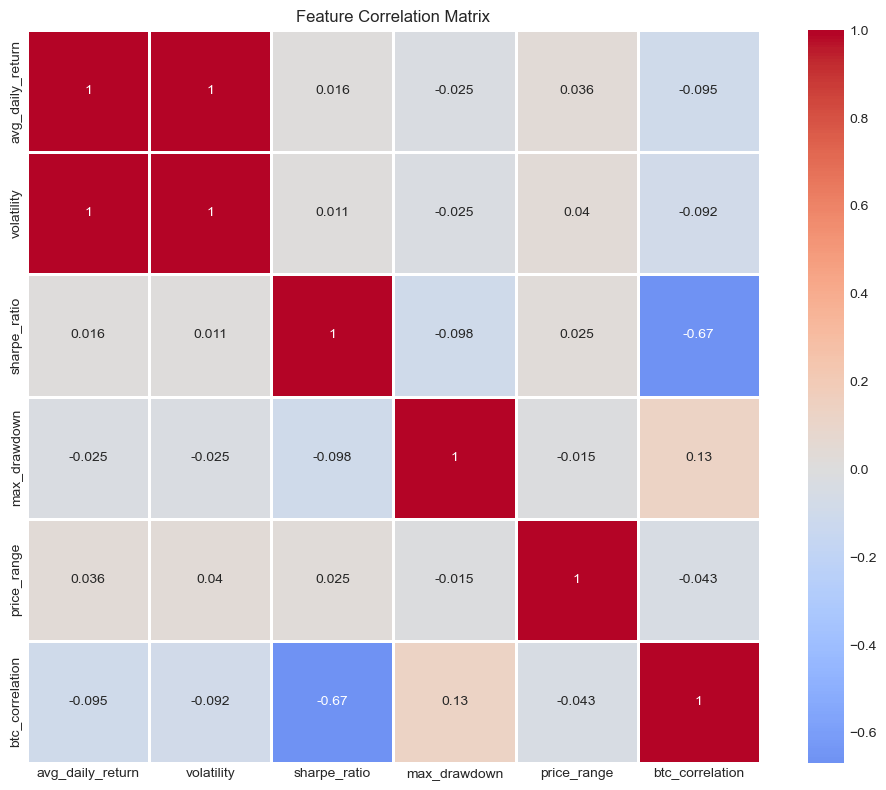

In [8]:
# Visualize feature correlations
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 4. Determine Optimal Number of Clusters

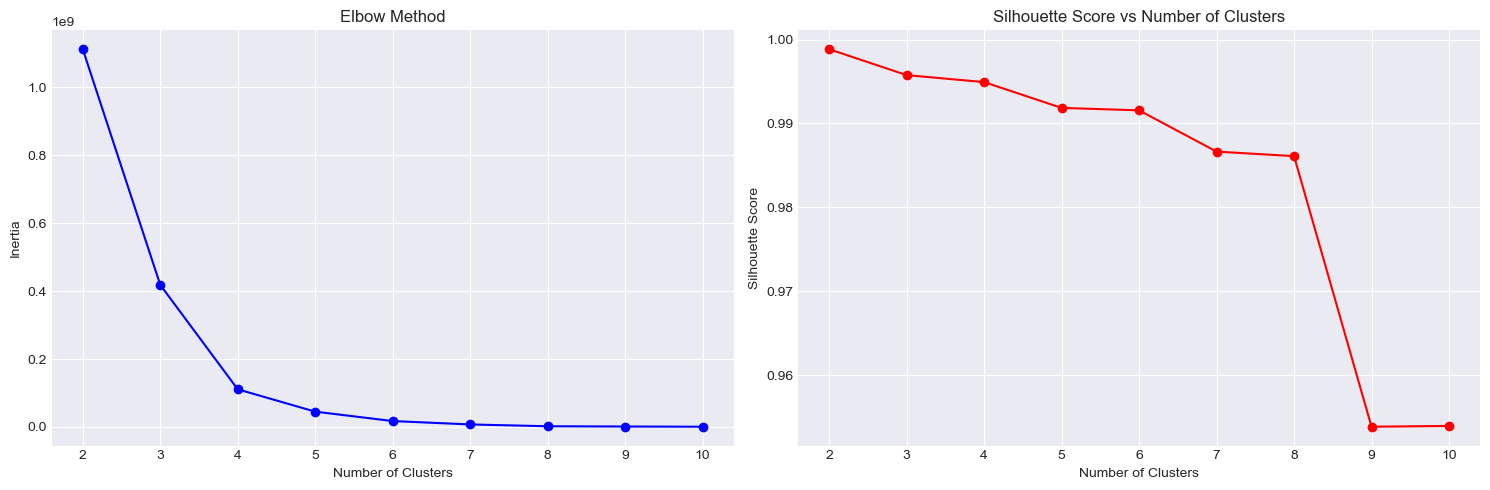

Optimal number of clusters based on silhouette score: 2


In [9]:
# Elbow method
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
ax1.plot(K, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

# Silhouette scores
ax2.plot(K, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

## 5. K-Means Clustering

In [10]:
# Apply K-means with optimal k
optimal_k = 5  # You can adjust based on the elbow/silhouette analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to features dataframe
features_df['kmeans_cluster'] = kmeans_labels

# Print cluster sizes
print("K-Means Cluster Sizes:")
print(features_df['kmeans_cluster'].value_counts().sort_index())

K-Means Cluster Sizes:
kmeans_cluster
0    1378
1       1
2       1
3       1
4       2
Name: count, dtype: int64


## 6. Hierarchical Clustering

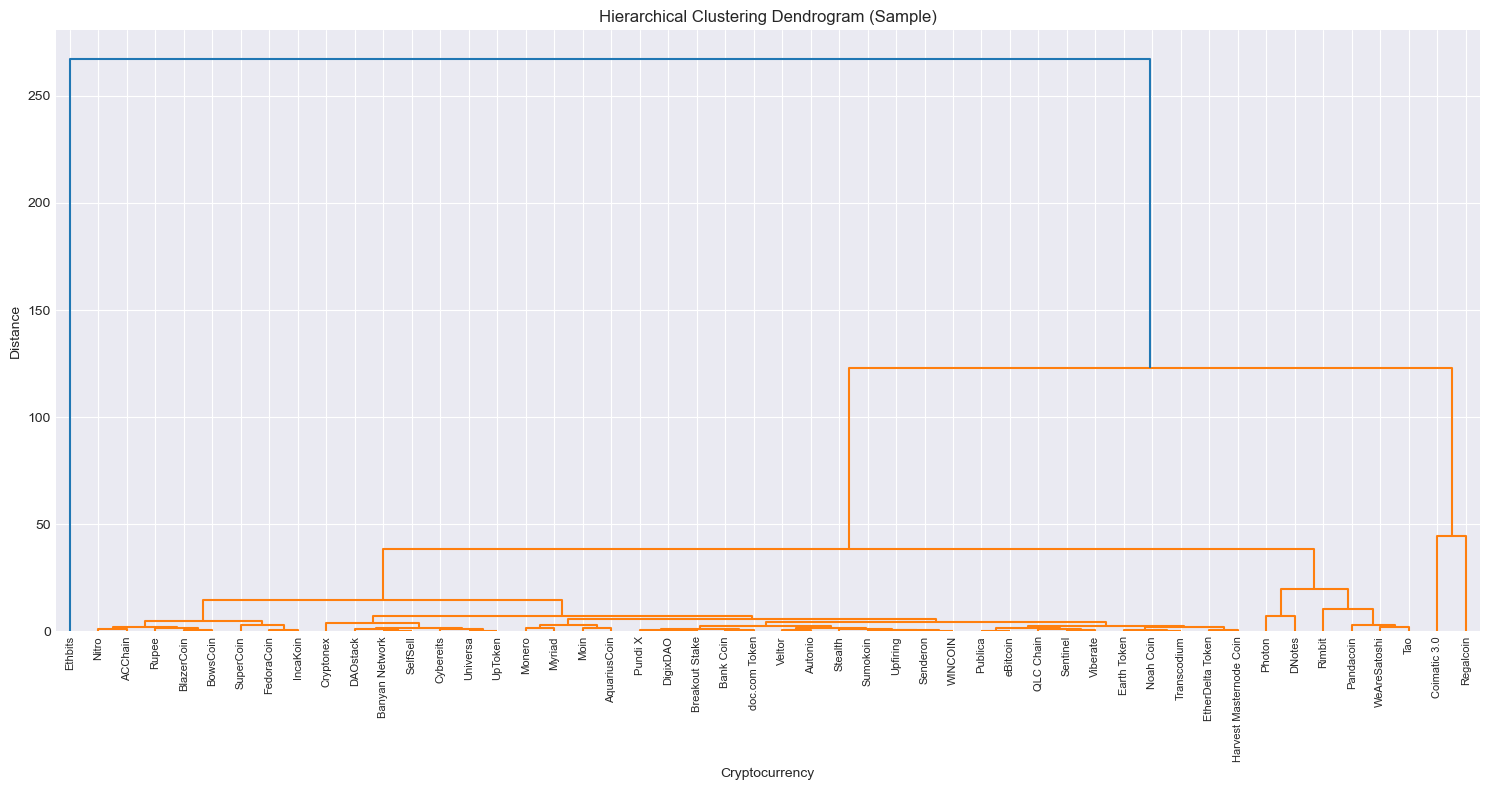

In [11]:
# Create dendrogram for a subset of data (for visualization)
sample_size = min(50, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]
sample_names = features_df.iloc[sample_indices]['name'].values

# Calculate linkage
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=sample_names, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Sample)')
plt.xlabel('Cryptocurrency')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [12]:
# Apply hierarchical clustering to full dataset
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

features_df['hierarchical_cluster'] = hierarchical_labels

# Print cluster sizes
print("Hierarchical Cluster Sizes:")
print(features_df['hierarchical_cluster'].value_counts().sort_index())

Hierarchical Cluster Sizes:
hierarchical_cluster
0    1378
1       2
2       1
3       1
4       1
Name: count, dtype: int64


## 7. Cluster Analysis and Profiling

In [13]:
# Analyze K-means clusters
cluster_profiles = features_df.groupby('kmeans_cluster')[feature_columns].agg(['mean', 'std'])

print("K-Means Cluster Profiles:")
print("=" * 80)

for cluster in range(optimal_k):
    cluster_data = features_df[features_df['kmeans_cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_data)} cryptocurrencies):")
    print(f"Average Daily Return: {cluster_data['avg_daily_return'].mean():.4f} (�{cluster_data['avg_daily_return'].std():.4f})")
    print(f"Volatility: {cluster_data['volatility'].mean():.4f} (�{cluster_data['volatility'].std():.4f})")
    print(f"Bitcoin Correlation: {cluster_data['btc_correlation'].mean():.3f} (�{cluster_data['btc_correlation'].std():.3f})")
    print(f"Top 5 coins: {', '.join(cluster_data.nlargest(5, 'avg_market_cap')['name'].values)}")

K-Means Cluster Profiles:

Cluster 0 (1378 cryptocurrencies):
Average Daily Return: 0.0312 (�0.1439)
Volatility: 0.5715 (�3.2590)
Bitcoin Correlation: 0.274 (�0.170)
Top 5 coins: Bitcoin, Ethereum, Bitcoin Cash, XRP, Cardano

Cluster 1 (1 cryptocurrencies):
Average Daily Return: 0.1190 (�nan)
Volatility: 1.3375 (�nan)
Bitcoin Correlation: 0.043 (�nan)
Top 5 coins: Dix Asset

Cluster 2 (1 cryptocurrencies):
Average Daily Return: 45.8808 (�nan)
Volatility: 1251.9225 (�nan)
Bitcoin Correlation: 0.009 (�nan)
Top 5 coins: AllSafe

Cluster 3 (1 cryptocurrencies):
Average Daily Return: 127.8958 (�nan)
Volatility: 2969.1936 (�nan)
Bitcoin Correlation: -0.091 (�nan)
Top 5 coins: Veritaseum

Cluster 4 (2 cryptocurrencies):
Average Daily Return: 40.7014 (�17.6886)
Volatility: 961.0461 (�367.4333)
Bitcoin Correlation: 0.014 (�0.004)
Top 5 coins: Global Cryptocurrency, STEX


In [14]:
# Create cluster interpretation
cluster_names = {
    0: "High Risk/High Return",
    1: "Stable Performers", 
    2: "Bitcoin Followers",
    3: "Volatile Altcoins",
    4: "Low Activity Coins"
}

# You should adjust these names based on actual cluster characteristics
features_df['cluster_name'] = features_df['kmeans_cluster'].map(cluster_names)

## 8. Visualization - PCA and Cluster Plots

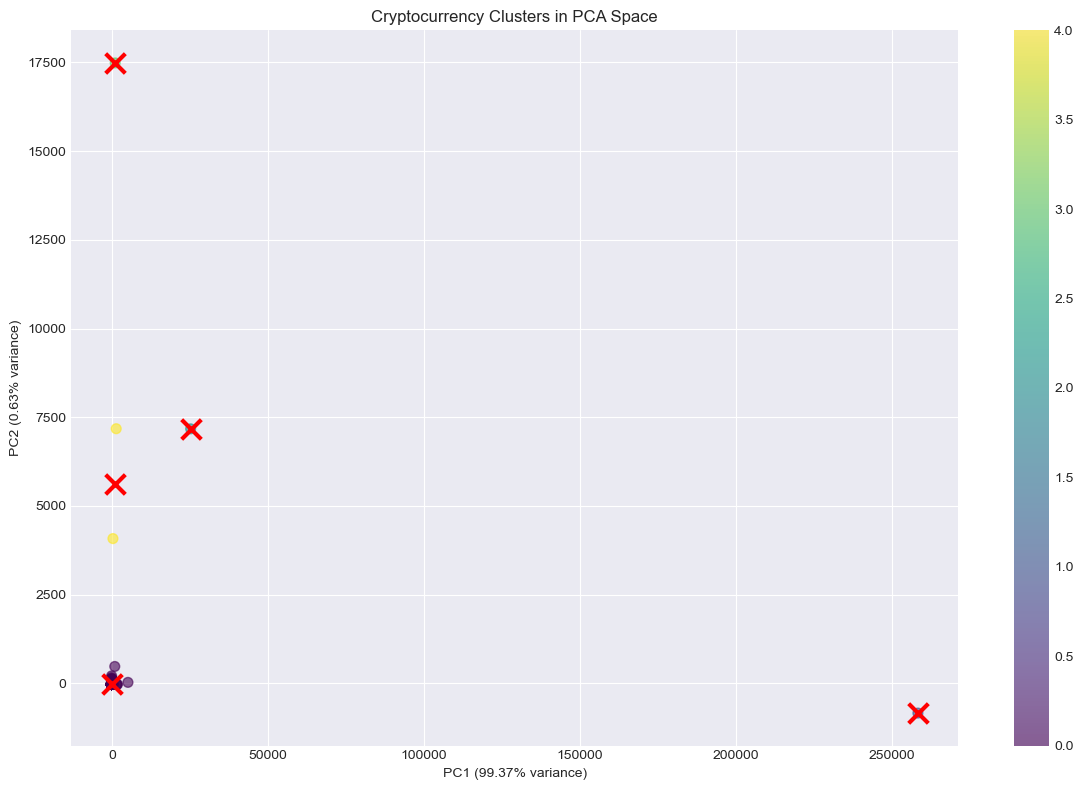

In [15]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters in PCA space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=kmeans_labels, cmap='viridis', 
                     alpha=0.6, s=50)
plt.colorbar(scatter)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Cryptocurrency Clusters in PCA Space')

# Add cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='red', marker='x', s=200, linewidths=3)

plt.tight_layout()
plt.show()

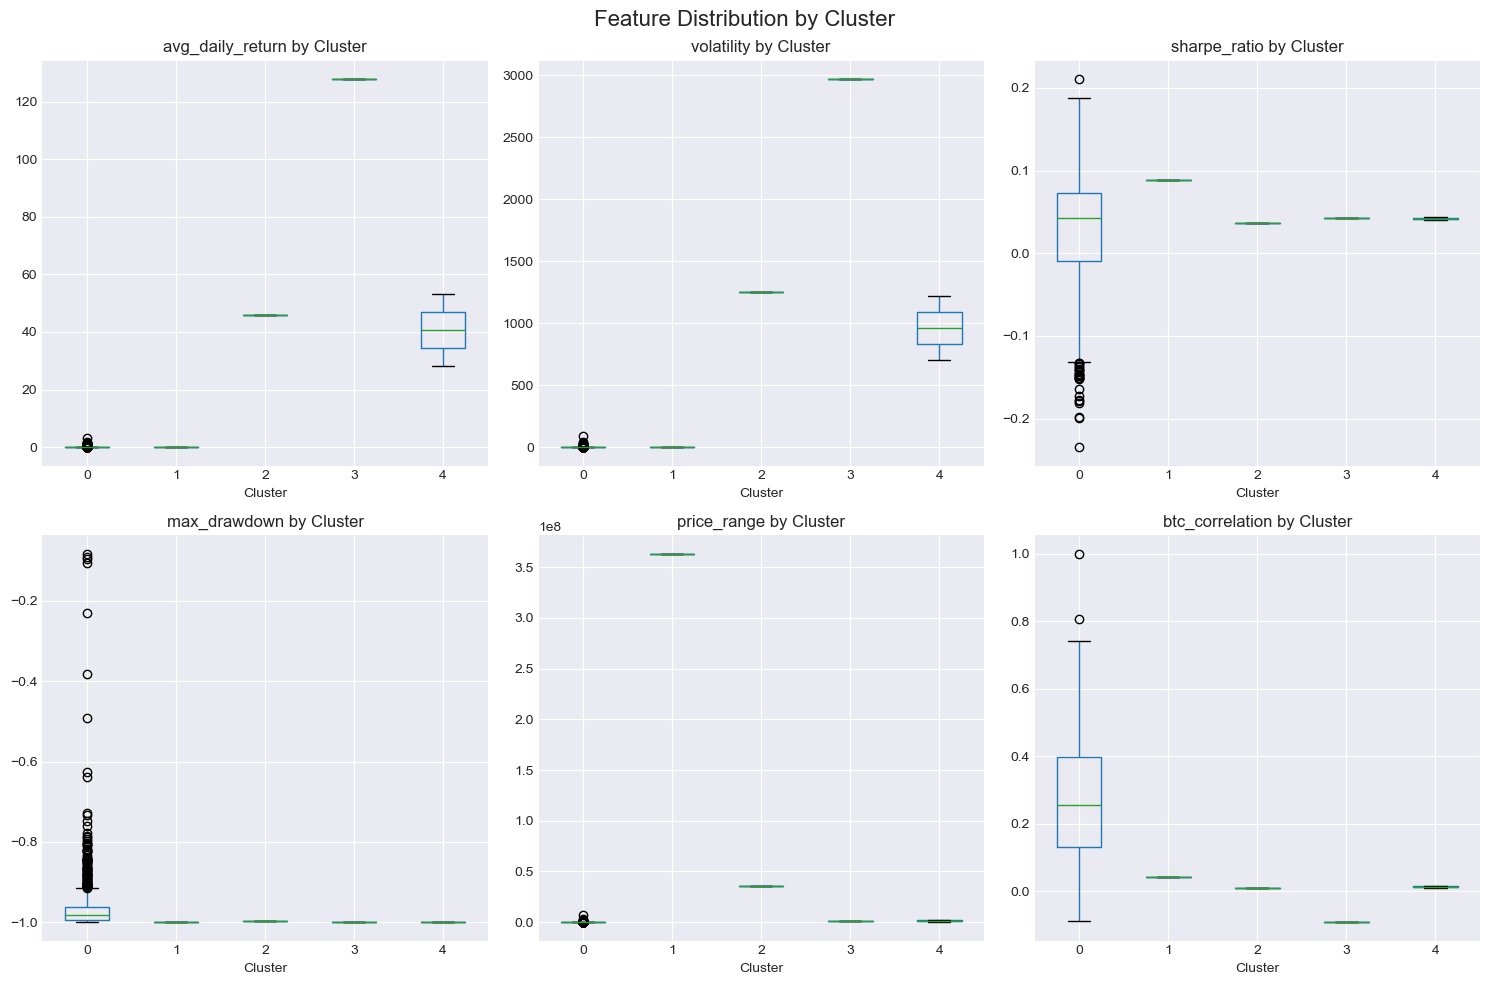

In [16]:
# Feature importance for clusters
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_columns[:6]):
    features_df.boxplot(column=feature, by='kmeans_cluster', ax=axes[i])
    axes[i].set_title(f'{feature} by Cluster')
    axes[i].set_xlabel('Cluster')
    
plt.suptitle('Feature Distribution by Cluster', size=16)
plt.tight_layout()
plt.show()

## 9. Generate Deliverables

In [17]:
# 1. Clustered Coin List
clustered_coins = features_df[['name', 'symbol', 'kmeans_cluster', 'cluster_name', 
                               'avg_daily_return', 'volatility', 'btc_correlation',
                               'avg_market_cap', 'days_traded']].copy()

clustered_coins = clustered_coins.sort_values(['kmeans_cluster', 'avg_market_cap'], 
                                             ascending=[True, False])

# Save to CSV
clustered_coins.to_csv('../reports/clustered_cryptocurrencies.csv', index=True)
print("Saved clustered coin list to ../reports/clustered_cryptocurrencies.csv")

# Display sample
print("\nSample of clustered coins:")
clustered_coins.head(10)

Saved clustered coin list to ../reports/clustered_cryptocurrencies.csv

Sample of clustered coins:


,name,symbol,kmeans_cluster,cluster_name,avg_daily_return,volatility,btc_correlation,avg_market_cap,days_traded
bitcoin,Bitcoin,BTC,0,High Risk/High Return,0.002660,0.044018,1.000000,3.787079e+10,2041
ethereum,Ethereum,ETH,0,High Risk/High Return,0.005986,0.074007,0.362593,2.080815e+10,1210
bitcoin-cash,Bitcoin Cash,BCH,0,High Risk/High Return,0.002655,0.095898,0.363545,1.557105e+10,494
ripple,XRP,XRP,0,High Risk/High Return,0.005397,0.089035,0.302471,6.294407e+09,1943
cardano,Cardano,ADA,0,High Risk/High Return,0.006788,0.120827,0.394094,5.316585e+09,424
eos,EOS,EOS,0,High Risk/High Return,0.007569,0.118947,0.404842,4.779075e+09,516
iota,IOTA,MIOTA,0,High Risk/High Return,0.002887,0.092177,0.548660,3.348558e+09,534
tron,TRON,TRX,0,High Risk/High Return,0.013117,0.146324,0.422274,2.296505e+09,442
neo,NEO,NEO,0,High Risk/High Return,0.009031,0.114761,0.331794,1.862780e+09,811
litecoin,Litecoin,LTC,0,High Risk/High Return,0.003372,0.073950,0.621876,1.634891e+09,2041


In [18]:
# 2. Cluster Summary Statistics
cluster_summary = features_df.groupby(['kmeans_cluster', 'cluster_name']).agg({
    'name': 'count',
    'avg_daily_return': ['mean', 'std'],
    'volatility': ['mean', 'std'],
    'sharpe_ratio': ['mean', 'std'],
    'btc_correlation': ['mean', 'std'],
    'avg_market_cap': ['mean', 'median']
})

cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary = cluster_summary.rename(columns={'name_count': 'coin_count'})

# Save summary
cluster_summary.to_csv('../reports/cluster_summary_statistics.csv')
print("\nCluster Summary Statistics:")
print(cluster_summary)


Cluster Summary Statistics:
                                      coin_count  avg_daily_return_mean   
kmeans_cluster cluster_name                                               
0              High Risk/High Return        1378               0.031216  \
1              Stable Performers               1               0.119011   
2              Bitcoin Followers               1              45.880842   
3              Volatile Altcoins               1             127.895831   
4              Low Activity Coins              2              40.701426   

                                      avg_daily_return_std  volatility_mean   
kmeans_cluster cluster_name                                                   
0              High Risk/High Return              0.143904         0.571538  \
1              Stable Performers                       NaN         1.337499   
2              Bitcoin Followers                       NaN      1251.922491   
3              Volatile Altcoins                  

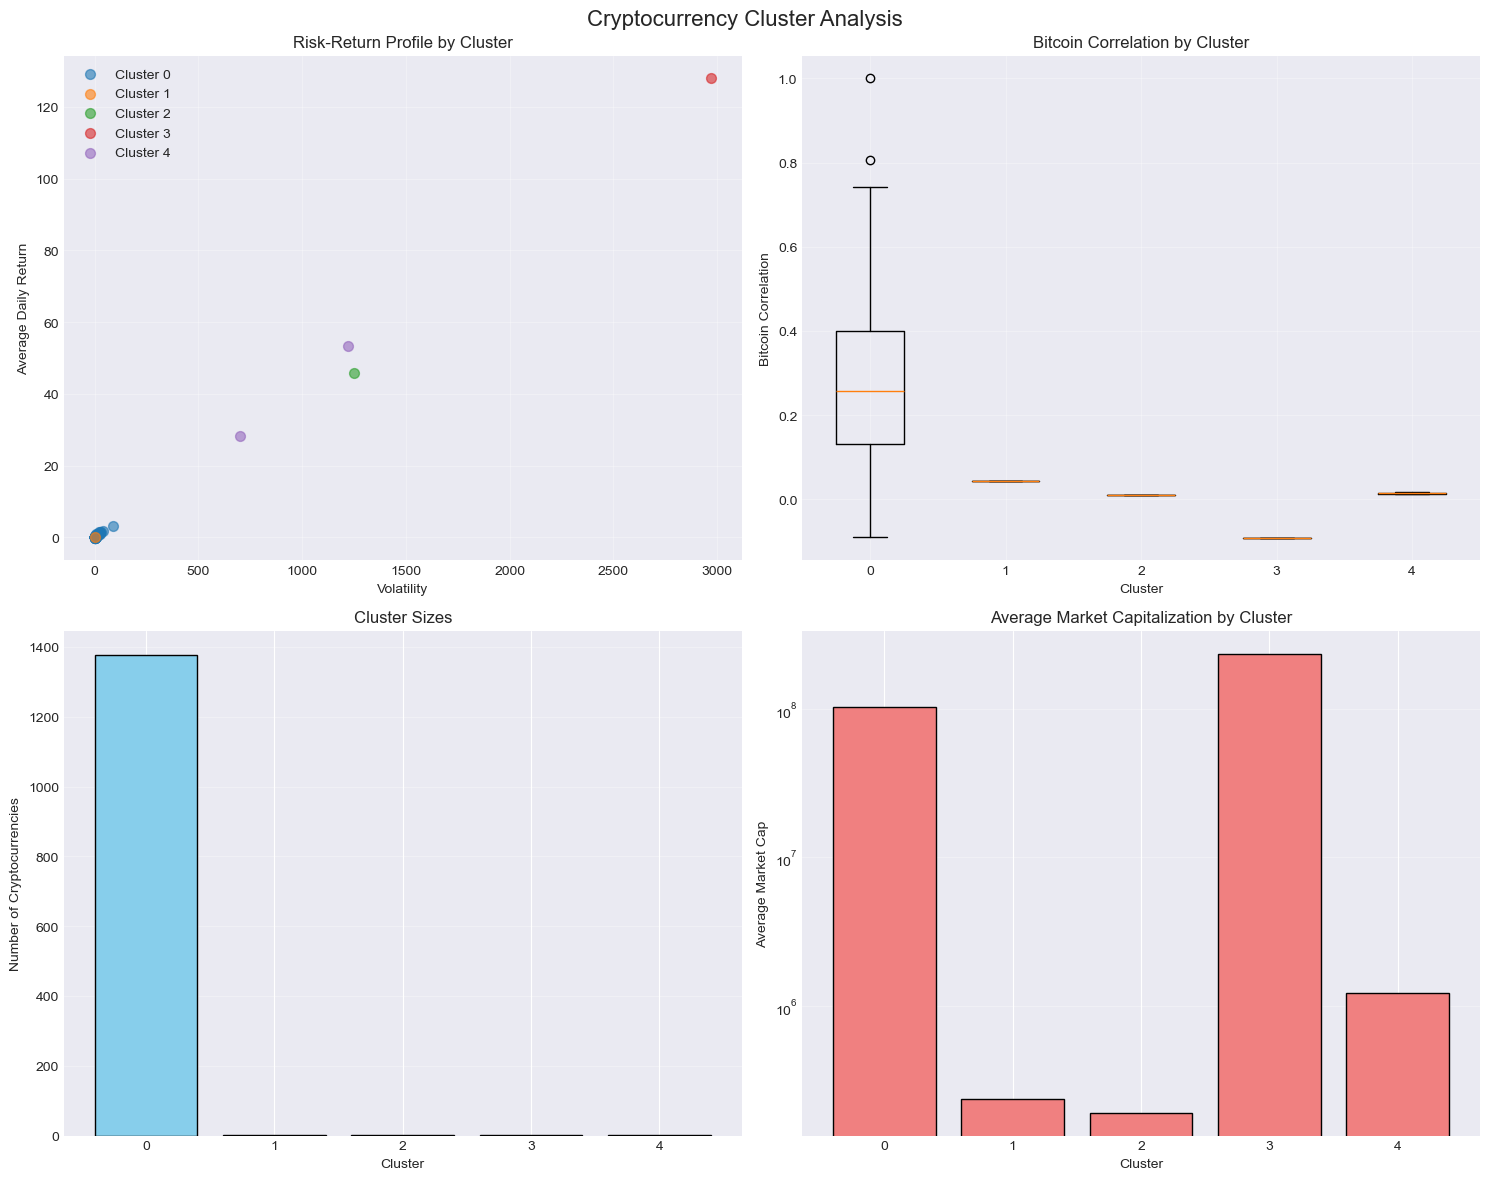

Visual report saved to ../reports/cluster_analysis_visual_report.png


In [19]:
# 3. Visual Report - Cluster Characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Subplot 1: Return vs Volatility
ax1 = axes[0, 0]
for cluster in range(optimal_k):
    cluster_data = features_df[features_df['kmeans_cluster'] == cluster]
    ax1.scatter(cluster_data['volatility'], cluster_data['avg_daily_return'], 
               label=f'Cluster {cluster}', alpha=0.6, s=50)
ax1.set_xlabel('Volatility')
ax1.set_ylabel('Average Daily Return')
ax1.set_title('Risk-Return Profile by Cluster')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Bitcoin Correlation Distribution
ax2 = axes[0, 1]
cluster_btc_corr = features_df.groupby('kmeans_cluster')['btc_correlation'].apply(list)
ax2.boxplot(cluster_btc_corr.values, labels=cluster_btc_corr.index)
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Bitcoin Correlation')
ax2.set_title('Bitcoin Correlation by Cluster')
ax2.grid(True, alpha=0.3)

# Subplot 3: Cluster Sizes
ax3 = axes[1, 0]
cluster_sizes = features_df['kmeans_cluster'].value_counts().sort_index()
ax3.bar(cluster_sizes.index, cluster_sizes.values, color='skyblue', edgecolor='black')
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Number of Cryptocurrencies')
ax3.set_title('Cluster Sizes')
ax3.grid(True, alpha=0.3, axis='y')

# Subplot 4: Average Market Cap by Cluster
ax4 = axes[1, 1]
avg_market_cap_by_cluster = features_df.groupby('kmeans_cluster')['avg_market_cap'].mean().sort_index()
ax4.bar(avg_market_cap_by_cluster.index, avg_market_cap_by_cluster.values, 
        color='lightcoral', edgecolor='black')
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Average Market Cap')
ax4.set_title('Average Market Capitalization by Cluster')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_yscale('log')

plt.suptitle('Cryptocurrency Cluster Analysis', size=16)
plt.tight_layout()
plt.savefig('../reports/cluster_analysis_visual_report.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visual report saved to ../reports/cluster_analysis_visual_report.png")

In [20]:
# 4. Individual Cluster Reports
import os
os.makedirs('../reports/cluster_profiles', exist_ok=True)

for cluster in range(optimal_k):
    cluster_data = features_df[features_df['kmeans_cluster'] == cluster]
    
    # Create figure for each cluster
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Feature distributions
    cluster_data['avg_daily_return'].hist(ax=axes[0, 0], bins=20, edgecolor='black')
    axes[0, 0].set_title('Daily Return Distribution')
    axes[0, 0].set_xlabel('Average Daily Return')
    
    cluster_data['volatility'].hist(ax=axes[0, 1], bins=20, edgecolor='black')
    axes[0, 1].set_title('Volatility Distribution')
    axes[0, 1].set_xlabel('Volatility')
    
    cluster_data['btc_correlation'].hist(ax=axes[1, 0], bins=20, edgecolor='black')
    axes[1, 0].set_title('Bitcoin Correlation Distribution')
    axes[1, 0].set_xlabel('Correlation with Bitcoin')
    
    # Top coins by market cap
    top_coins = cluster_data.nlargest(10, 'avg_market_cap')[['name', 'avg_market_cap']]
    axes[1, 1].barh(range(len(top_coins)), top_coins['avg_market_cap'].values)
    axes[1, 1].set_yticks(range(len(top_coins)))
    axes[1, 1].set_yticklabels(top_coins['name'].values)
    axes[1, 1].set_xlabel('Average Market Cap')
    axes[1, 1].set_title('Top 10 Coins by Market Cap')
    axes[1, 1].set_xscale('log')
    
    plt.suptitle(f'Cluster {cluster} Profile: {cluster_names.get(cluster, "Unknown")} ({len(cluster_data)} coins)', 
                size=14)
    plt.tight_layout()
    plt.savefig(f'../reports/cluster_profiles/cluster_{cluster}_profile.png', dpi=300, bbox_inches='tight')
    plt.close()

print(f"Individual cluster profiles saved to ../reports/cluster_profiles/")

Individual cluster profiles saved to ../reports/cluster_profiles/


In [21]:
# 5. Save feature importance and model metadata
model_metadata = {
    'n_clusters': optimal_k,
    'clustering_method': 'KMeans',
    'features_used': feature_columns,
    'scaling_method': 'RobustScaler',
    'total_cryptocurrencies': len(features_df),
    'silhouette_score': silhouette_score(X_scaled, kmeans_labels),
    'cluster_names': cluster_names,
    'date_generated': str(pd.Timestamp.now())
}

with open('../reports/clustering_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

print("\nClustering metadata saved to ../reports/clustering_metadata.json")
print(f"\nFinal silhouette score: {model_metadata['silhouette_score']:.3f}")


Clustering metadata saved to ../reports/clustering_metadata.json

Final silhouette score: 0.992


## 10. Summary and Recommendations

In [22]:
print("=" * 80)
print("CRYPTOCURRENCY CLUSTERING ANALYSIS SUMMARY")
print("=" * 80)
print(f"\nTotal cryptocurrencies analyzed: {len(features_df)}")
print(f"Optimal number of clusters: {optimal_k}")
print(f"Clustering quality (silhouette score): {silhouette_score(X_scaled, kmeans_labels):.3f}")

print("\nCluster Characteristics:")
for cluster in range(optimal_k):
    cluster_data = features_df[features_df['kmeans_cluster'] == cluster]
    print(f"\nCluster {cluster} - {cluster_names.get(cluster, 'Unknown')}:")
    print(f"  - Size: {len(cluster_data)} cryptocurrencies")
    print(f"  - Avg Return: {cluster_data['avg_daily_return'].mean():.4f}")
    print(f"  - Avg Volatility: {cluster_data['volatility'].mean():.4f}")
    print(f"  - BTC Correlation: {cluster_data['btc_correlation'].mean():.3f}")
    print(f"  - Notable coins: {', '.join(cluster_data.nlargest(3, 'avg_market_cap')['name'].values)}")

print("\n" + "=" * 80)
print("All deliverables have been generated and saved to the ../reports/ directory")
print("=" * 80)

CRYPTOCURRENCY CLUSTERING ANALYSIS SUMMARY

Total cryptocurrencies analyzed: 1383
Optimal number of clusters: 5
Clustering quality (silhouette score): 0.992

Cluster Characteristics:

Cluster 0 - High Risk/High Return:
  - Size: 1378 cryptocurrencies
  - Avg Return: 0.0312
  - Avg Volatility: 0.5715
  - BTC Correlation: 0.274
  - Notable coins: Bitcoin, Ethereum, Bitcoin Cash

Cluster 1 - Stable Performers:
  - Size: 1 cryptocurrencies
  - Avg Return: 0.1190
  - Avg Volatility: 1.3375
  - BTC Correlation: 0.043
  - Notable coins: Dix Asset

Cluster 2 - Bitcoin Followers:
  - Size: 1 cryptocurrencies
  - Avg Return: 45.8808
  - Avg Volatility: 1251.9225
  - BTC Correlation: 0.009
  - Notable coins: AllSafe

Cluster 3 - Volatile Altcoins:
  - Size: 1 cryptocurrencies
  - Avg Return: 127.8958
  - Avg Volatility: 2969.1936
  - BTC Correlation: -0.091
  - Notable coins: Veritaseum

Cluster 4 - Low Activity Coins:
  - Size: 2 cryptocurrencies
  - Avg Return: 40.7014
  - Avg Volatility: 961.0